In [9]:
import numpy as np
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt

from numpy import cos, sin, arcsin, sqrt
from math import radians
import seaborn as sns
from jupyter_dash import JupyterDash

import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np

from sklearn.cluster import KMeans

# need for token (mapbox)
px.set_mapbox_access_token("pk.eyJ1IjoiZmlsaXBrcmFzbmlxaSIsImEiOiJja2luOW9jdmgwa3J3MnpvNXhkNGJ6MWFtIn0.eevoM5byqvtc1nC0oXpuOw")

def normalize(data, columns):
    for column in columns:
        data.loc[:, column] = (data[column]-data[column].mean())/data[column].std()
    return data

def fix_coords(data):
    data['LAT'], data['LNG'] = pd.to_numeric(data['LAT_Y'],errors='coerce'), pd.to_numeric(data['LONG_X'],errors='coerce')
    return data

def add_relative_coords(data):
    minLat, maxLat, minLng, maxLng = data['LAT'].min(), data['LAT'].max(), data['LNG'].min(), data['LNG'].max()
    data['rLAT'], data['rLNG'] = (data['LAT'] - minLat) / (maxLat - minLat), (data['LNG'] - minLng) / (maxLng - minLng)
    return data

def remove_outliers(df, col):
    df = df.dropna(subset=[col])
    return df[df[col] < np.percentile(df[col],95)]

data_path = "/Users/filipkrasniqi/Documents/Datasets.tmp/traffic-covid/"
cities = ["Milano", "ROMA", "TORINO"]

# Handling data

## Import data

In [16]:
data_milano = fix_coords(pd.read_pickle("{}LTE_1800_{}.pkl".format(data_path, cities[0])))
data_milano_2 = fix_coords(pd.read_pickle("{}LTE_1800_{}_P2.pkl".format(data_path, cities[0])))

## Removing outliers
Done separately: it would be even better to do that separately for each month

In [17]:
data_milano = remove_outliers(data_milano, "DL_VOL")
data_milano = remove_outliers(data_milano, "Hin_Succ")
data_milano_2 = remove_outliers(data_milano_2, "DL_VOL")
data_milano_2 = remove_outliers(data_milano_2, "Hin_Succ")
df = pd.concat([data_milano, data_milano_2])
df["USERNUM_AVG"] = df["USERNUM_AVG"].astype(float)

## Adding relevant columns: LAT, LNG both relative and absolute

In [18]:
df = add_relative_coords(df)

## Selecting columns and dropping rows having NaN vals

In [19]:
columns = ["LAT", "LNG", "rLAT", "rLNG", "USERNUM_AVG", "DL_VOL", "Hin_Succ", 'ECELL_ID']
df = df[columns]
print("BEFORE", df.shape)
df.dropna(inplace=True)
print("AFTER", df.shape)

BEFORE (4246761, 8)
AFTER (3612675, 8)


# Clustering

## Applying k-means

In [52]:
columns_clustering = ["rLAT", "rLNG"]#, "USERNUM_AVG", "DL_VOL", "Hin_Succ"]
k = 9 # as the number of districts in Milan
kmeans = KMeans(n_clusters = k, init ='k-means++')
kmeans.fit(df[columns_clustering]) # Compute k-means clustering.

KMeans(n_clusters=9)

## Assigning cluster to each point

In [53]:
df['cluster'] = kmeans.fit_predict(df[columns_clustering])

## Assigning to each cell the cluster present more times

In [54]:
df.head()

,LAT,LNG,rLAT,rLNG,USERNUM_AVG,DL_VOL,Hin_Succ,ECELL_ID,cluster
0,45.481224,9.190639,0.59743,0.600952,1.335833,116064.0,1.0,1584c220e0dc1b3,1
1,45.481224,9.190639,0.59743,0.600952,0.066389,57512.0,0.0,1584c220e0dc1b3,1
2,45.481224,9.190639,0.59743,0.600952,0.130278,59656.0,3.0,1584c220e0dc1b3,1
3,45.481224,9.190639,0.59743,0.600952,0.505278,654528.0,1.0,1584c220e0dc1b3,1
4,45.481224,9.190639,0.59743,0.600952,0.586667,1104400.0,1.0,1584c220e0dc1b3,1


In [55]:
df_groupped = df.groupby('ECELL_ID')
df_output = df_groupped['cluster'].apply(lambda x: x.value_counts().index[0]).reset_index()
df_output.set_index('ECELL_ID', inplace=True)
df_output['LAT'], df_output['LNG'] = df_groupped['LAT'].mean(), df_groupped['LNG'].mean()
df_output['DL_VOL'], df_output['USERNUM_AVG'], df_output['Hin_Succ'] = \
    df_groupped['DL_VOL'].mean(), df_groupped['USERNUM_AVG'].mean(), df_groupped['Hin_Succ'].mean()
df_output.shape

(1044, 6)

In [56]:
fig = px.scatter_mapbox(df_output, lat="LAT", lon="LNG", color='cluster',
                        color_discrete_sequence="Inferno", zoom=10, height=300)
fig.update_layout(mapbox_style="dark")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

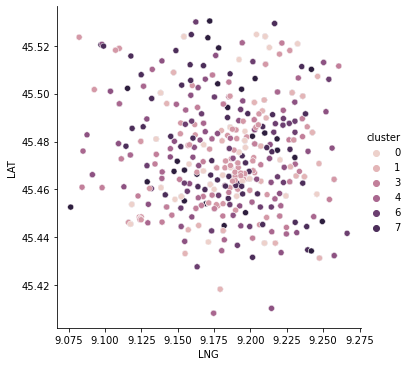

In [43]:
sns.relplot(
    data=df_output, x="LNG", y="LAT", hue="cluster",kind="scatter"
)